In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Imports

In [ ]:
import os
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter
from tensorflow.keras.preprocessing.image import ImageDataGenerator

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (Conv2D, MaxPooling2D, Dense, Dropout, BatchNormalization, Flatten)
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

### paths

In [ ]:
dir = "/content/drive/MyDrive/Tumour-20260202T182951Z-3-001/Tumour"
train_dir = os.path.join(dir, "train")
test_dir = os.path.join(dir, "test")
val_dir = os.path.join(dir, "valid")

### finding classes

In [ ]:
classes = sorted([
    d for d in os.listdir(train_dir)
    if os.path.isdir(os.path.join(train_dir, d))
])
print("classes:", classes)
print("number of classes:", len(classes))

classes: ['glioma', 'meningioma', 'no_tumor', 'pituitary']
number of classes: 4


### counting image for classes

In [ ]:
train_counts = {}
val_counts = {}
test_counts = {}

for cls in classes:
    train_counts[cls] = len(os.listdir(os.path.join(train_dir, cls)))
    val_counts[cls] = len(os.listdir(os.path.join(val_dir, cls)))
    test_counts[cls] = len(os.listdir(os.path.join(test_dir, cls)))

print("train samples:", train_counts)
print("val samples:", val_counts)
print("test samples:", test_counts)

train samples: {'glioma': 564, 'meningioma': 358, 'no_tumor': 335, 'pituitary': 438}
val samples: {'glioma': 161, 'meningioma': 124, 'no_tumor': 99, 'pituitary': 118}
test samples: {'glioma': 80, 'meningioma': 63, 'no_tumor': 49, 'pituitary': 54}


### visualizing class imbalance

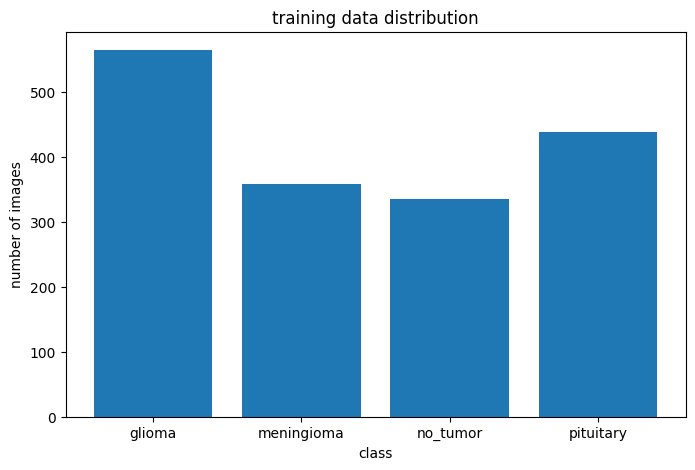

In [ ]:
plt.figure(figsize=(8, 5))
plt.bar(train_counts.keys(), train_counts.values())
plt.xlabel("class")
plt.ylabel("number of images")
plt.title("training data distribution")
plt.show()


### checking image resolution

In [ ]:
image_sizes = []

for cls in classes:
    class_path = os.path.join(train_dir, cls)
    for img_name in os.listdir(class_path)[:50]:  # sample 50 images
        img_path = os.path.join(class_path, img_name)
        img = cv2.imread(img_path)
        if img is not None:
            h, w, _ = img.shape
            image_sizes.append((h, w))

sizes_df = pd.DataFrame(image_sizes, columns=["height", "width"])
print(sizes_df.describe())


       height  width
count   200.0  200.0
mean    640.0  640.0
std       0.0    0.0
min     640.0  640.0
25%     640.0  640.0
50%     640.0  640.0
75%     640.0  640.0
max     640.0  640.0


### sample images

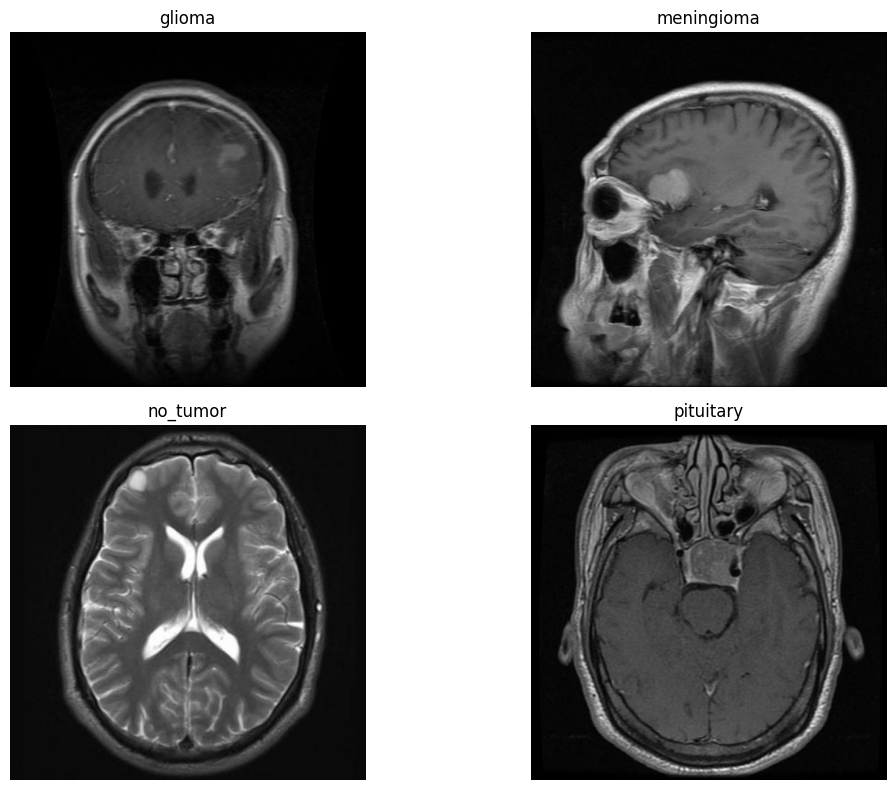

In [ ]:
plt.figure(figsize=(12, 8))

for i, cls in enumerate(classes):
    img_name = os.listdir(os.path.join(train_dir, cls))[0]
    img_path = os.path.join(train_dir, cls, img_name)

    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    plt.subplot(2, 2, i + 1)
    plt.imshow(img)
    plt.title(cls)
    plt.axis("off")

plt.tight_layout()
plt.show()


### data generators

In [ ]:
img_size = (224, 224)
batch_size = 32

train_datagen = ImageDataGenerator(
    rescale=1.0 / 255.0
)

val_datagen = ImageDataGenerator(
    rescale=1.0 / 255.0
)

test_datagen = ImageDataGenerator(
    rescale=1.0 / 255.0
)


In [ ]:
train_generator = train_datagen.flow_from_directory(
    directory=train_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode="categorical",
    shuffle=True
)

val_generator = val_datagen.flow_from_directory(
    directory=val_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode="categorical",
    shuffle=False
)

test_generator = test_datagen.flow_from_directory(
    directory=test_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode="categorical",
    shuffle=False
)


Found 1695 images belonging to 4 classes.
Found 502 images belonging to 4 classes.
Found 246 images belonging to 4 classes.


### checking class order

In [ ]:
print("train class indices:", train_generator.class_indices)
print("val class indices:", val_generator.class_indices)
print("test class indices:", test_generator.class_indices)

train class indices: {'glioma': 0, 'meningioma': 1, 'no_tumor': 2, 'pituitary': 3}
val class indices: {'glioma': 0, 'meningioma': 1, 'no_tumor': 2, 'pituitary': 3}
test class indices: {'glioma': 0, 'meningioma': 1, 'no_tumor': 2, 'pituitary': 3}


In [ ]:
images, labels = next(train_generator)

print("image batch shape:", images.shape)
print("label batch shape:", labels.shape)
print("pixel range:", images.min(), images.max())


image batch shape: (32, 224, 224, 3)
label batch shape: (32, 4)
pixel range: 0.0 1.0


### training data with augmentation

In [ ]:
train_datagen = ImageDataGenerator(
    rescale=1.0 / 255.0,
    rotation_range=15,
    width_shift_range=0.05,
    height_shift_range=0.05,
    zoom_range=0.1,
    brightness_range=(0.9, 1.1),
    horizontal_flip=True
)


In [ ]:
val_datagen = ImageDataGenerator(
    rescale=1.0 / 255.0
)

test_datagen = ImageDataGenerator(
    rescale=1.0 / 255.0
)


In [ ]:
train_generator = train_datagen.flow_from_directory(
    directory=train_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode="categorical",
    shuffle=True
)

val_generator = val_datagen.flow_from_directory(
    directory=val_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode="categorical",
    shuffle=False
)

test_generator = test_datagen.flow_from_directory(
    directory=test_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode="categorical",
    shuffle=False
)


Found 1695 images belonging to 4 classes.
Found 502 images belonging to 4 classes.
Found 246 images belonging to 4 classes.


### augumented images

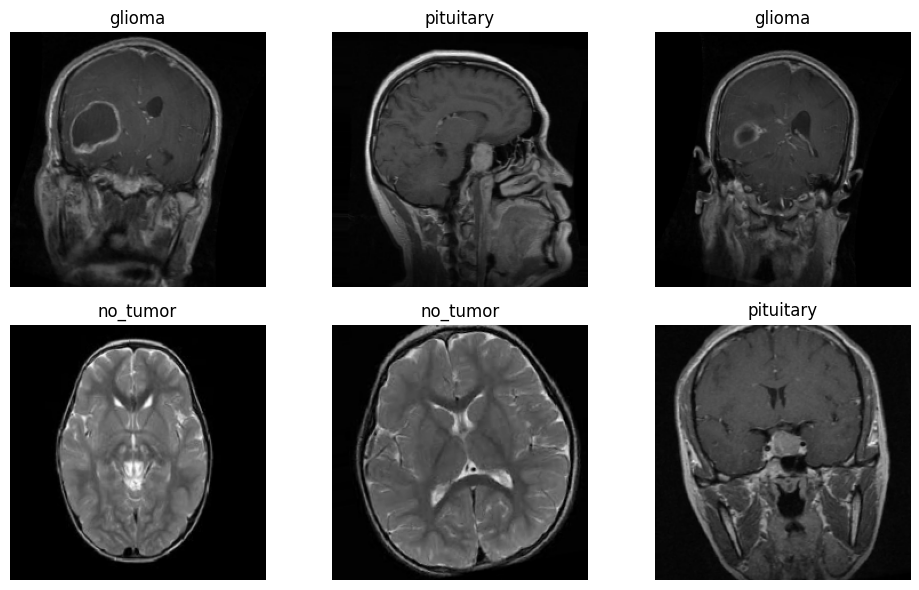

In [ ]:
images, labels = next(train_generator)
class_names = list(train_generator.class_indices.keys())

plt.figure(figsize=(10, 6))
for i in range(6):
    plt.subplot(2, 3, i + 1)
    plt.imshow(images[i])
    plt.title(class_names[np.argmax(labels[i])])
    plt.axis("off")

plt.tight_layout()
plt.show()


### custom CNN

In [ ]:
num_classes = train_generator.num_classes

model = Sequential()

model.add(Conv2D(32, (3, 3), activation="relu", input_shape=(224, 224, 3)))
model.add(BatchNormalization())
model.add(MaxPooling2D(2, 2))

model.add(Conv2D(64, (3, 3), activation="relu"))
model.add(BatchNormalization())
model.add(MaxPooling2D(2, 2))

model.add(Conv2D(128, (3, 3), activation="relu"))
model.add(BatchNormalization())
model.add(MaxPooling2D(2, 2))
model.add(Dropout(0.3))

model.add(Flatten())
model.add(Dense(256, activation="relu"))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(num_classes, activation="softmax"))


/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:
model.compile(optimizer=Adam(learning_rate=0.0001),loss="categorical_crossentropy",metrics=["accuracy"])


In [ ]:
model.summary()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 222, 222, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 222, 222, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 109, 109, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 109, 109, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 52, 52, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 52, 52, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 26, 26, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 26, 26, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 86528)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │    22,151,424 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 4)              │         1,028 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 22,247,620 (84.87 MB)

 Trainable params: 22,246,660 (84.86 MB)

 Non-trainable params: 960 (3.75 KB)

5

### callbacks

In [ ]:
early_stop = EarlyStopping(
    monitor="val_loss",
    patience=5,
    restore_best_weights=True
)

checkpoint = ModelCheckpoint(
    "best_custom_cnn.h5",
    monitor="val_loss",
    save_best_only=True
)


training the model

In [ ]:
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=30,
    callbacks=[early_stop, checkpoint]
)


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/30
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 721ms/step - accuracy: 0.6271 - loss: 1.3113

53/53 ━━━━━━━━━━━━━━━━━━━━ 237s 4s/step - accuracy: 0.6282 - loss: 1.3068 - val_accuracy: 0.2351 - val_loss: 2.8402
Epoch 2/30
53/53 ━━━━━━━━━━━━━━━━━━━━ 33s 615ms/step - accuracy: 0.7296 - loss: 0.8252 - val_accuracy: 0.2351 - val_loss: 6.4323
Epoch 3/30
53/53 ━━━━━━━━━━━━━━━━━━━━ 39s 726ms/step - accuracy: 0.7740 - loss: 0.6581 - val_accuracy: 0.2351 - val_loss: 6.4224
Epoch 4/30
53/53 ━━━━━━━━━━━━━━━━━━━━ 33s 623ms/step - accuracy: 0.7938 - loss: 0.5716 - val_accuracy: 0.2351 - val_loss: 6.5419
Epoch 5/30
53/53 ━━━━━━━━━━━━━━━━━━━━ 32s 611ms/step - accuracy: 0.7702 - loss: 0.6164 - val_accuracy: 0.2430 - val_loss: 5.2438
Epoch 6/30
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 585ms/step - accuracy: 0.8254 - loss: 0.4843

53/53 ━━━━━━━━━━━━━━━━━━━━ 35s 656ms/step - accuracy: 0.8250 - loss: 0.4851 - val_accuracy: 0.3367 - val_loss: 2.5555
Epoch 7/30
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 552ms/step - accuracy: 0.8199 - loss: 0.5084

53/53 ━━━━━━━━━━━━━━━━━━━━ 33s 613ms/step - accuracy: 0.8199 - loss: 0.5084 - val_accuracy: 0.5637 - val_loss: 1.4659
Epoch 8/30
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 545ms/step - accuracy: 0.8375 - loss: 0.4911

53/53 ━━━━━━━━━━━━━━━━━━━━ 41s 613ms/step - accuracy: 0.8374 - loss: 0.4908 - val_accuracy: 0.7151 - val_loss: 0.9315
Epoch 9/30
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 556ms/step - accuracy: 0.8434 - loss: 0.4759

53/53 ━━━━━━━━━━━━━━━━━━━━ 33s 620ms/step - accuracy: 0.8435 - loss: 0.4754 - val_accuracy: 0.7610 - val_loss: 0.6161
Epoch 10/30
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 558ms/step - accuracy: 0.8509 - loss: 0.4696

53/53 ━━━━━━━━━━━━━━━━━━━━ 38s 673ms/step - accuracy: 0.8509 - loss: 0.4698 - val_accuracy: 0.8526 - val_loss: 0.4283
Epoch 11/30
53/53 ━━━━━━━━━━━━━━━━━━━━ 32s 595ms/step - accuracy: 0.8435 - loss: 0.4133 - val_accuracy: 0.8406 - val_loss: 0.5151
Epoch 12/30
53/53 ━━━━━━━━━━━━━━━━━━━━ 32s 601ms/step - accuracy: 0.8791 - loss: 0.3346 - val_accuracy: 0.8625 - val_loss: 0.4503
Epoch 13/30
53/53 ━━━━━━━━━━━━━━━━━━━━ 32s 600ms/step - accuracy: 0.8641 - loss: 0.3733 - val_accuracy: 0.8606 - val_loss: 0.4782
Epoch 14/30
53/53 ━━━━━━━━━━━━━━━━━━━━ 32s 596ms/step - accuracy: 0.8586 - loss: 0.4098 - val_accuracy: 0.8147 - val_loss: 0.5798
Epoch 15/30
53/53 ━━━━━━━━━━━━━━━━━━━━ 33s 619ms/step - accuracy: 0.8680 - loss: 0.3643 - val_accuracy: 0.8466 - val_loss: 0.4695


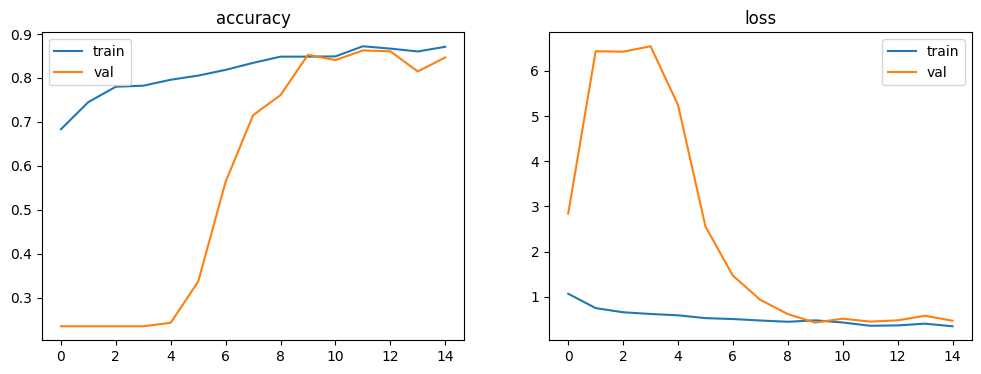

In [ ]:
plt.figure(figsize=(12, 4))

# accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history["accuracy"], label="train")
plt.plot(history.history["val_accuracy"], label="val")
plt.title("accuracy")
plt.legend()

# loss
plt.subplot(1, 2, 2)
plt.plot(history.history["loss"], label="train")
plt.plot(history.history["val_loss"], label="val")
plt.title("loss")
plt.legend()

plt.show()


6

evaluating on test data

In [ ]:
test_loss, test_accuracy = model.evaluate(test_generator)
print("test accuracy:", test_accuracy)


8/8 ━━━━━━━━━━━━━━━━━━━━ 68s 10s/step - accuracy: 0.8404 - loss: 0.4254
test accuracy: 0.857723593711853


In [ ]:
y_prob = model.predict(test_generator)
y_pred = np.argmax(y_prob, axis=1)
y_true = test_generator.classes


8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 234ms/step


In [ ]:
from sklearn.metrics import classification_report

class_names = list(test_generator.class_indices.keys())

print(classification_report(y_true, y_pred, target_names=class_names))


              precision    recall  f1-score   support

      glioma       0.96      0.88      0.92        80
  meningioma       0.74      0.76      0.75        63
    no_tumor       0.79      0.84      0.81        49
   pituitary       0.93      0.96      0.95        54

    accuracy                           0.86       246
   macro avg       0.85      0.86      0.86       246
weighted avg       0.86      0.86      0.86       246



confusion matrix

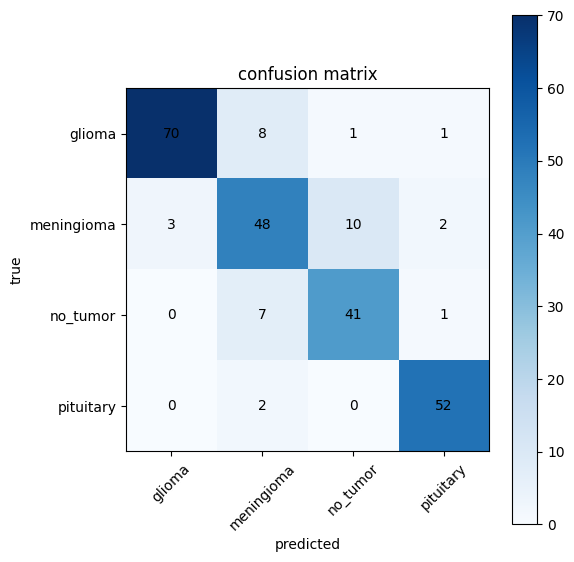

In [ ]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(6, 6))
plt.imshow(cm, cmap="Blues")
plt.title("confusion matrix")
plt.colorbar()

plt.xticks(range(len(class_names)), class_names, rotation=45)
plt.yticks(range(len(class_names)), class_names)

for i in range(len(class_names)):
    for j in range(len(class_names)):
        plt.text(j, i, cm[i, j], ha="center", va="center")

plt.xlabel("predicted")
plt.ylabel("true")
plt.tight_layout()
plt.show()


In [ ]:
model.save("custom_cnn_final.h5")


## transfer learning

In [ ]:
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import GlobalAveragePooling2D
from tensorflow.keras.models import Model

base_model = MobileNetV2(
    weights="imagenet",
    include_top=False,
    input_shape=(224, 224, 3)
)

base_model.trainable = False


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


### custom classification head

In [ ]:
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(256, activation="relu")(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)
outputs = Dense(train_generator.num_classes, activation="softmax")(x)
tl_model = Model(inputs=base_model.input, outputs=outputs)

In [ ]:
tl_model.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)

In [ ]:
tl_history = tl_model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=15,
    callbacks=[early_stop]
)

Epoch 1/15
53/53 ━━━━━━━━━━━━━━━━━━━━ 75s 1s/step - accuracy: 0.3860 - loss: 1.8100 - val_accuracy: 0.5956 - val_loss: 0.9949
Epoch 2/15
53/53 ━━━━━━━━━━━━━━━━━━━━ 32s 600ms/step - accuracy: 0.7394 - loss: 0.7091 - val_accuracy: 0.6912 - val_loss: 0.7606
Epoch 3/15
53/53 ━━━━━━━━━━━━━━━━━━━━ 31s 580ms/step - accuracy: 0.7836 - loss: 0.5827 - val_accuracy: 0.7450 - val_loss: 0.6653
Epoch 4/15
53/53 ━━━━━━━━━━━━━━━━━━━━ 31s 590ms/step - accuracy: 0.7863 - loss: 0.5766 - val_accuracy: 0.7709 - val_loss: 0.6119
Epoch 5/15
53/53 ━━━━━━━━━━━━━━━━━━━━ 32s 611ms/step - accuracy: 0.8496 - loss: 0.4286 - val_accuracy: 0.7849 - val_loss: 0.5750
Epoch 6/15
53/53 ━━━━━━━━━━━━━━━━━━━━ 31s 590ms/step - accuracy: 0.8294 - loss: 0.4435 - val_accuracy: 0.8068 - val_loss: 0.5415
Epoch 7/15
53/53 ━━━━━━━━━━━━━━━━━━━━ 31s 582ms/step - accuracy: 0.8631 - loss: 0.3616 - val_accuracy: 0.8207 - val_loss: 0.5385
Epoch 8/15
53/53 ━━━━━━━━━━━━━━━━━━━━ 32s 613ms/step - accuracy: 0.8904 - loss: 0.3445 - val_accurac

In [ ]:
base_model.trainable = True

for layer in base_model.layers[:-30]:
    layer.trainable = False

tl_model.compile(
    optimizer=Adam(learning_rate=1e-5),
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)

tl_finetune_history = tl_model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=10,
    callbacks=[early_stop]
)


Epoch 1/10
53/53 ━━━━━━━━━━━━━━━━━━━━ 65s 888ms/step - accuracy: 0.7324 - loss: 0.8210 - val_accuracy: 0.8287 - val_loss: 0.5287
Epoch 2/10
53/53 ━━━━━━━━━━━━━━━━━━━━ 32s 601ms/step - accuracy: 0.7969 - loss: 0.6005 - val_accuracy: 0.7888 - val_loss: 0.7594
Epoch 3/10
53/53 ━━━━━━━━━━━━━━━━━━━━ 31s 581ms/step - accuracy: 0.8303 - loss: 0.4838 - val_accuracy: 0.7629 - val_loss: 0.9253
Epoch 4/10
53/53 ━━━━━━━━━━━━━━━━━━━━ 31s 583ms/step - accuracy: 0.8539 - loss: 0.4162 - val_accuracy: 0.7570 - val_loss: 1.0280
Epoch 5/10
53/53 ━━━━━━━━━━━━━━━━━━━━ 32s 606ms/step - accuracy: 0.8615 - loss: 0.3827 - val_accuracy: 0.7490 - val_loss: 1.0759
Epoch 6/10
53/53 ━━━━━━━━━━━━━━━━━━━━ 31s 584ms/step - accuracy: 0.8785 - loss: 0.3552 - val_accuracy: 0.7610 - val_loss: 1.0293


In [ ]:
tl_loss, tl_accuracy = tl_model.evaluate(test_generator)
print("transfer learning test accuracy:", tl_accuracy)


8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 152ms/step - accuracy: 0.8327 - loss: 0.4744
transfer learning test accuracy: 0.7967479825019836


In [ ]:
tl_prob = tl_model.predict(test_generator)
tl_pred = np.argmax(tl_prob, axis=1)


8/8 ━━━━━━━━━━━━━━━━━━━━ 10s 700ms/step


In [ ]:
print("transfer learning report")
print(classification_report(y_true, tl_pred, target_names=class_names))


transfer learning report
              precision    recall  f1-score   support

      glioma       0.77      0.97      0.86        80
  meningioma       0.83      0.46      0.59        63
    no_tumor       0.97      0.71      0.82        49
   pituitary       0.73      1.00      0.84        54

    accuracy                           0.80       246
   macro avg       0.83      0.79      0.78       246
weighted avg       0.82      0.80      0.78       246



comparision

In [ ]:
comparison_df = pd.DataFrame({
    "model": ["custom cnn", "mobilenetv2"],
    "test_accuracy": [test_accuracy, tl_accuracy]
})

print(comparison_df)


         model  test_accuracy
0   custom cnn       0.857724
1  mobilenetv2       0.796748


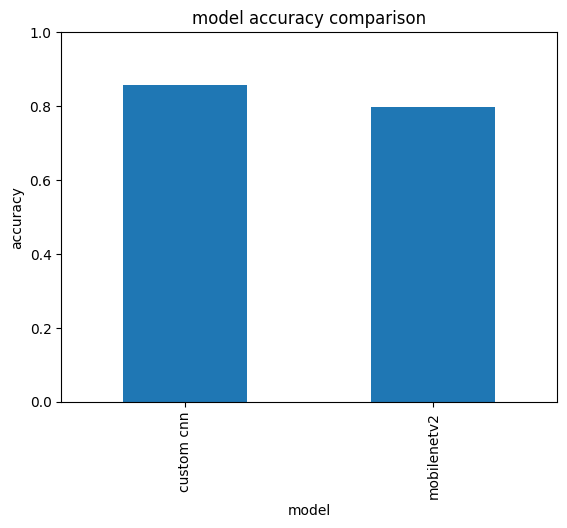

In [ ]:
comparison_df.set_index("model")["test_accuracy"].plot(kind="bar")
plt.title("model accuracy comparison")
plt.ylabel("accuracy")
plt.ylim(0, 1)
plt.show()


In [ ]:
tl_model.save("mobilenetv2_final.h5")


In [ ]:
tl_checkpoint = ModelCheckpoint(
    "best_mobilenetv2.h5",
    monitor="val_loss",
    save_best_only=True
)

tl_early_stop = EarlyStopping(
    monitor="val_loss",
    patience=3,
    restore_best_weights=True
)


In [ ]:
tl_history = tl_model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=10,
    callbacks=[tl_checkpoint, tl_early_stop]
)


Epoch 1/10
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 543ms/step - accuracy: 0.7842 - loss: 0.6145

53/53 ━━━━━━━━━━━━━━━━━━━━ 33s 606ms/step - accuracy: 0.7843 - loss: 0.6137 - val_accuracy: 0.7928 - val_loss: 0.7548
Epoch 2/10
53/53 ━━━━━━━━━━━━━━━━━━━━ 31s 586ms/step - accuracy: 0.8229 - loss: 0.5303 - val_accuracy: 0.7510 - val_loss: 0.9828
Epoch 3/10
53/53 ━━━━━━━━━━━━━━━━━━━━ 33s 615ms/step - accuracy: 0.8398 - loss: 0.4402 - val_accuracy: 0.7470 - val_loss: 1.0873
Epoch 4/10
53/53 ━━━━━━━━━━━━━━━━━━━━ 31s 589ms/step - accuracy: 0.8661 - loss: 0.3762 - val_accuracy: 0.7470 - val_loss: 1.0920


In [ ]:
from tensorflow.keras.models import load_model

mobilenet_model = load_model("best_mobilenetv2.h5")
y_prob = mobilenet_model.predict(test_generator)
y_pred = np.argmax(y_prob, axis=1)
y_true = test_generator.classes
class_names = list(test_generator.class_indices.keys())
print(class_names)


8/8 ━━━━━━━━━━━━━━━━━━━━ 10s 845ms/step
['glioma', 'meningioma', 'no_tumor', 'pituitary']


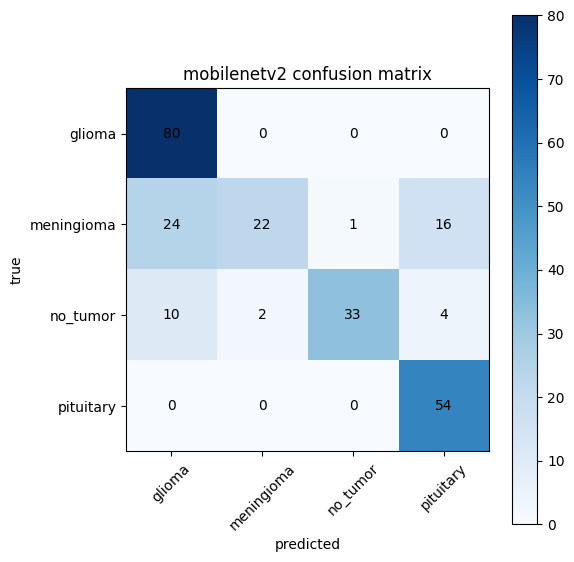

In [ ]:
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(6, 6))
plt.imshow(cm, cmap="Blues")
plt.title("mobilenetv2 confusion matrix")
plt.colorbar()

plt.xticks(range(len(class_names)), class_names, rotation=45)
plt.yticks(range(len(class_names)), class_names)

for i in range(len(class_names)):
    for j in range(len(class_names)):
        plt.text(j, i, cm[i, j], ha="center", va="center")

plt.xlabel("predicted")
plt.ylabel("true")
plt.tight_layout()
plt.show()



8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 198ms/step
['glioma', 'meningioma', 'no_tumor', 'pituitary']


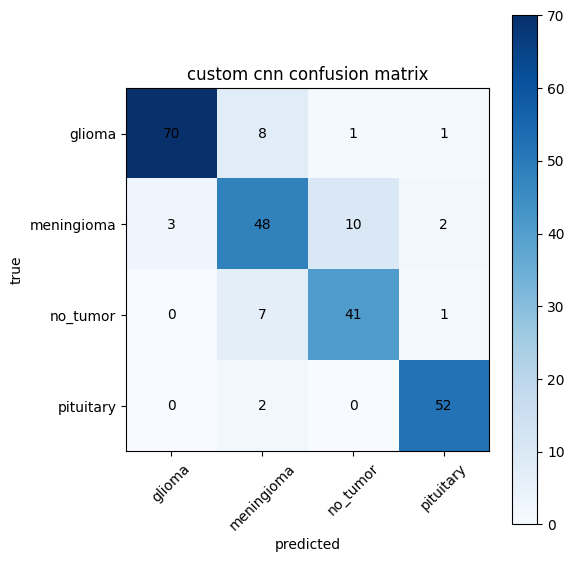

In [ ]:
custom_model = load_model("best_custom_cnn.h5")
y_prob_cnn = custom_model.predict(test_generator)
y_pred_cnn = np.argmax(y_prob_cnn, axis=1)
y_true = test_generator.classes

class_names = list(test_generator.class_indices.keys())
print(class_names)

cm_cnn = confusion_matrix(y_true, y_pred_cnn)
plt.figure(figsize=(6, 6))
plt.imshow(cm_cnn, cmap="Blues")
plt.title("custom cnn confusion matrix")
plt.colorbar()

plt.xticks(range(len(class_names)), class_names, rotation=45)
plt.yticks(range(len(class_names)), class_names)

for i in range(len(class_names)):
    for j in range(len(class_names)):
        plt.text(j, i, cm_cnn[i, j], ha="center", va="center")

plt.xlabel("predicted")
plt.ylabel("true")
plt.tight_layout()
plt.show()


custom cnn best